In [1]:
import pandas as pd
import numpy as np
import tempfile
import PIL
import matplotlib.pyplot as plt
import pickle
import time
%matplotlib inline
import skimage.filters

In [2]:
brain_scans = pickle.load(open('Amit/Labeled Data/labeled_data.pkl','rb')).iloc[:100]

In [3]:
brain_scans

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel22492,pixel22493,pixel22494,pixel22495,pixel22496,pixel22497,pixel22498,pixel22499,pixel22500,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,8.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
test_scan = brain_scans.iloc[1,:-1]

In [5]:
image_vector_2d = np.array(test_scan.copy()).reshape(150, 150)
image_vector_2d

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

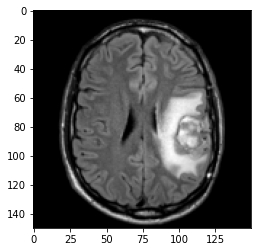

In [6]:
plt.imshow(image_vector_2d,cmap='gray')
plt.show()

### binarize

In [7]:
def binarize(img_vector, threshold):
    return [0 if pixel <= threshold else pixel for pixel in img_vector]

In [19]:
def binarize_dataset(dataset, automate_threshold = True, t = 0.3):
    binarize_dataset = dataset.copy()
    for num in range(len(binarize_dataset)):
        img_vector_norm = binarize_dataset.iloc[num] / np.array(binarize_dataset.iloc[num]).max()
        if automate_threshold == True:
            t = skimage.filters.threshold_otsu(img_vector_norm)
            binarize_dataset.iloc[num] = binarize(img_vector_norm, t)
        else:
            binarize_dataset.iloc[num] = binarize(img_vector_norm, t)
    return binarize_dataset

In [27]:
%%time
binarize_brain_scans = binarize_dataset(brain_scans.iloc[:, :-1], False, 0.5)

CPU times: user 838 ms, sys: 31.3 ms, total: 870 ms
Wall time: 837 ms


### crop binarized images

In [10]:
def crop_single_image(image_vector,old_dim,new_dim,show_stages = True):
    #Store Vector as a 2D vector (square pixel representation of image)
    image_vector_2d = np.array(image_vector.copy()).reshape(old_dim)
    
    if show_stages == True:
        print('Original Image')
        plt.imshow(image_vector_2d,cmap='gray')
        plt.show()
    
    #Store max ink signal across rows and columns
    row_maxes = np.max(image_vector_2d,axis=1)
    col_maxes = np.max(image_vector_2d,axis=0)
    
    #Find tightest possible bounds for image where ink signal begins and ends
    #LEFT/RIGHT BOUNDS, TOP/BOTTOM BOUNDS
    left_most,right_most,top_most,bottom_most = 0,0,0,0
    switch_col = 0 #toggle to switch between capturing left most ink signal and right most ink signal
    switch_row = 0 #toggle to switch between capturing top most ink signal and bottom most ink signal
    for num in range(len(row_maxes)):
        #LEFT/RIGHT BOUNDS
        if switch_col == 0 and col_maxes[num] != 0:
            left_most = num
            switch_col = 1
        elif switch_col == 1 and col_maxes[num] == 0:
            right_most = num - 1
            switch_col = 2
            
        #TOP/BOTTOM BOUNDS
        if switch_row == 0 and row_maxes[num] != 0:
            top_most = num
            switch_row = 1
        elif switch_row == 1 and row_maxes[num] == 0:
            bottom_most = num - 1
            switch_row = 2
        
        #Early break if cropped bounds have been found
        if switch_col == 2 and switch_row == 2:
            break
        
        #If on last iteration bottom or right bound has not been found
        if num == len(row_maxes) - 1 and switch_col == 1:
            right_most = num
        if num == len(row_maxes) - 1 and switch_row == 1:
            bottom_most = num
        
    #Cropped image vector according to bounds identified
    cropped_image_vector_2d = image_vector_2d[top_most:bottom_most + 1,left_most:right_most + 1].copy()
    
    if show_stages == True:
        print('Cropped Image around top/bottom most and left/right most instances of ink signal')
        plt.imshow(cropped_image_vector_2d,cmap='gray')
        plt.show()
    
    #Cast image as a square image if needed to preserve aspect ratios
    #Capture shape of cropped image and difference in size across dimensions
    height,width = cropped_image_vector_2d.shape
    size_diff = abs(height - width) #diff between height and width dimensions
    gapfill_1 = int(size_diff/2) #amount of blank space to add to one side of shorter dimension
    gapfill_2 = size_diff - gapfill_1 #amount of blank space to add to the other side
    
    if height < width: #if height of image is less than width, add symmetrical padding height wise to make image square
        #Add symmetrical blank spacing to top and bottom of image
        cropped_image_vector_2d = np.vstack((np.zeros((gapfill_1,width)),cropped_image_vector_2d)) #Add to top
        cropped_image_vector_2d = np.vstack((cropped_image_vector_2d,np.zeros((gapfill_2,width)))) #Add to bottom
    elif width < height: #if width of image is less than height, add symmetrical padding width wise to make image square
        cropped_image_vector_2d = np.hstack((np.zeros((height,gapfill_1)),cropped_image_vector_2d)) #Add to left
        cropped_image_vector_2d = np.hstack((cropped_image_vector_2d,np.zeros((height,gapfill_2)))) #Add to right
    
    if show_stages == True and height != width:
        print('Centered Version of Cropped Image with symmetric padding added to short axis')
        plt.imshow(cropped_image_vector_2d,cmap='gray')
        plt.show()
        
    #Resize as needed (only if cropped image is not the size of the new dimensions)
    height,width = cropped_image_vector_2d.shape
    if (height,width) != new_dim:
        temp = tempfile.TemporaryFile()
        plt.imsave(temp,cropped_image_vector_2d,cmap='gray') #save array as image
        img = PIL.Image.open(temp).convert('L') #open greyscale image
        img = img.resize(new_dim) #resize to new dimensions
        cropped_image_vector_2d = np.array(img)
    
    if show_stages == True:
        print('Final Image')
        plt.imshow(cropped_image_vector_2d,cmap='gray')
        plt.show()
    
    return cropped_image_vector_2d

In [11]:
def crop_dataset(image_dataset,old_dim,new_dim):
    cropped_images = image_dataset.copy()
    for num in range(len(cropped_images)):
        cropped_images.iloc[num] = crop_single_image(cropped_images.iloc[num],
                                                     old_dim,new_dim,False).flatten()
    return cropped_images

In [28]:
crop_binarize_dataset = crop_dataset(binarize_brain_scans.iloc[:,:],(150,150),(150,150))

In [29]:
crop_binarize_dataset

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel22491,pixel22492,pixel22493,pixel22494,pixel22495,pixel22496,pixel22497,pixel22498,pixel22499,pixel22500
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### trinarize

In [31]:
def trinarize(img_vector, t1, t2):
    if t2 == 100:
        t2 = skimage.filters.threshold_otsu(np.array([i for i in img_vector if i > t1]))
        return [pixel if pixel >= t2 else 0 if pixel <= t1 else 0.5 for pixel in img_vector]
    else:
        return [pixel if pixel >= t2 else 0 if pixel <= t1 else 0.5 for pixel in img_vector]
        

In [32]:
def trinarize_dataset(dataset, automate_threshold = True, t1 = 0.2, t2 = 0.8):
    trinarize_dataset = dataset.copy()
    for num in range(len(trinarize_dataset)):
        img_vector_norm = trinarize_dataset.iloc[num] / np.array(trinarize_dataset.iloc[num]).max()
        if automate_threshold == True:
            t1 = skimage.filters.threshold_otsu(img_vector_norm)
            trinarize_dataset.iloc[num] = trinarize(img_vector_norm, t1, t2 = 100)
        else:
            trinarize_dataset.iloc[num] = trinarize(img_vector_norm, t1, t2)
    return trinarize_dataset

In [33]:
%%time
trinarize_brain_scans = trinarize_dataset(brain_scans.iloc[:, :-1], True)

CPU times: user 1.57 s, sys: 63.5 ms, total: 1.64 s
Wall time: 1.6 s


### crop trinarized image

In [34]:
crop_trinarize_dataset = crop_dataset(trinarize_brain_scans.iloc[:,:],(150,150),(150,150))

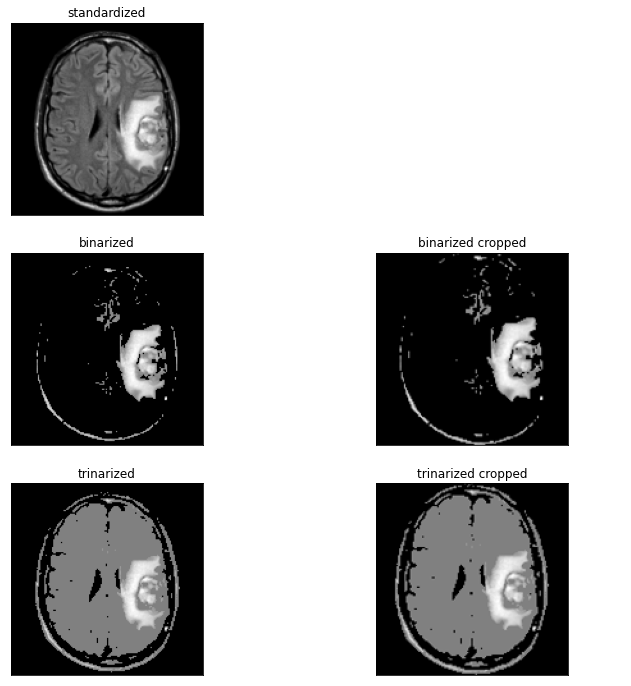

In [35]:
for i in range(1, 2):
    fig, ax = plt.subplots(3, 2, figsize = (12, 12))
    ax[0][0].imshow(np.array((brain_scans.iloc[:, :-1]).iloc[i]).reshape(150, 150), cmap='gray')
    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    ax[0][0].title.set_text('standardized')
    
    ax[1][0].imshow(np.array(binarize_brain_scans.iloc[i]).reshape(150, 150), cmap='gray')
    ax[1][0].set_xticks([])
    ax[1][0].set_yticks([])
    ax[1][0].title.set_text('binarized')
    
    ax[1][1].imshow(np.array(crop_binarize_dataset.iloc[i]).reshape(150, 150), cmap='gray')
    ax[1][1].set_xticks([])
    ax[1][1].set_yticks([])
    ax[1][1].title.set_text('binarized cropped')
    
    ax[2][0].imshow(np.array(trinarize_brain_scans.iloc[i]).reshape(150, 150), cmap='gray')
    ax[2][0].set_xticks([])
    ax[2][0].set_yticks([])
    ax[2][0].title.set_text('trinarized')
    
    ax[2][1].imshow(np.array(crop_trinarize_dataset.iloc[i]).reshape(150, 150), cmap='gray')
    ax[2][1].set_xticks([])
    ax[2][1].set_yticks([])
    ax[2][1].title.set_text('trinarized cropped')
    
    ax[0][1].axis('off')
    plt.show()   
    